In this notebook, we will learn how to design a quantum circuit in [PyQuil](https://pyquil.readthedocs.io/en/stable/) for a given Hamiltonian and run the circuit on the Rigetti's Quantum Virtual Machine (QVM) and the Aspen quantum processor (the quantum computer!).  PyQuil is a python library developed by Rigetti for designing quantum circuits and interfacing with their quantum computer over the cloud.

You can get started right away running quantum circuits with the QVM by downloading the [Forest SDK](https://www.rigetti.com/forest) from Rigetti.  With this, you can run your code locally on your computer.  In order to run jobs on the quantum processor, you must request an invite from Rigetti.

The Hamiltonian we will use for our example is for a one-dimensional Ising spin chain in an external transverse magnetic field:

$$H(t) = -J_z \sum_{i=1}^{N-1} \sigma_{i}^z \sigma_{i+1}^z - \epsilon_{ph}cos(\omega_{ph}t) \sum_{i=1}^{N} \sigma_{i}^x$$

In order to simulate the evolution of the qubits under this Hamitonian, we must apply the time-evolution operator $U(t)$ to the qubits.

$$U(t) = Texp\{-\frac{i}{\hbar}\int_{0}^{t}H(t)dt\}$$

Since exponentiation of the Hamiltonian is difficult, two approximations are made:
(1) The time-dependence of $H(t)$ must be ignored on time scales smaller than some chosen, minimal time-step $\Delta t$.  The Hamiltonian can then be approximated as a piece-wise constant function that takes the constant value $H((j+\frac{1}{2})\Delta t)$ during the time interval $[j \Delta t, (j+1) \Delta t]$, where $j$ is some integer.
(2) Each matrix exponential must be approximated with the Trotter decomposition.  To perform the Trotter decomposition, the Hamiltonian must be divided into components that are each efficiently diagonalizable on their own

$$H(t) = H_x(t) = H_z $$ where 
$$H_z = -J_z \sum_{i=1}^{N-1} \sigma_{i}^z \sigma_{i+1}^z$$ 
$$H_x = \epsilon_{ph}cos(\omega_{ph}t) \sum_{i=1}^{N} \sigma_{i}^x$$

Thus, the time evolution operator is finally approximated as
$$U(n \Delta t) = \prod_{j=0}^{n-1} e^{-iH_{x}((j+ \frac{1}{2})\Delta t)\Delta t} e^{-iH_{z}\Delta t}$$

This circuit can be defined with the following function written in PyQuil:

In [28]:
#import all necessary PyQuil libraries and global constants
from pyquil.api import get_qc
from pyquil.quil import Program
from pyquil.paulis import PauliTerm, exponential_map
from pyquil.gates import RZ, Z, H, MEASURE, CNOT, RESET
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Physical constants, global variable
H_BAR = 0.658212    # eV*fs
Jz = 0.01183898    # eV, coupling coeff; Jz<0 is antiferromagenetic, Jz>0 is ferromagnetic
FREQ = 0.0048       # 1/fs, frequency of MoSe2 phonon

In [29]:
def evolution_circuit(qubits, delta_t, total_time, w_ph):
    """
    Define circuit for evolution of wavefunction, i.e.,
    H(t) = - Jz * sum_{i=1}^{N-1}(sigma_{z}^{i} * sigma_{z}^{i+1})
           - e_ph * cos(w_ph * t) * sum_{i=1}^{N}(sigma_{x}^{i})

    Args:
    - qubits: list of qubits in system
    - delta_t: unit of propagation time 
    - total_time: total time to evolve system
    - w_ph: angular frequency of phonon
    
    Return: 
    - pyquil.Program
    """

    # get the number of qubits
    nqubits = len(qubits)
    e_ph = 0.5*Jz
    #instantiate program object for return
    p = Program(RESET())

    # decalre time e_ph as a parameter
    # declare memory for read out
    ro = p.declare('ro', memory_type='BIT', memory_size=nqubits)

    # determine number of time steps to get to total time
    prop_steps = int(total_time / delta_t)
    
    # instantiate program object for the propagator to which
    # we add terms of Hamiltonian piece by piece
    for step in range(0,prop_steps):
        t = (step + 0.5) * delta_t
        propagator_t = Program()
        instr_set1 = []
        instr_set2 = []
        theta_x = -e_ph * np.cos(w_ph * t)

        #make coupling terms
        coupling_termsZ = []
        for i in range(0, nqubits-1):
            coupling_termsZ.append(PauliTerm("Z", qubits[i], Jz)*PauliTerm("Z", qubits[i+1]))
        #make transverse magnetization terms of Hamiltonian
        Hx = []
        for i in range(0,nqubits):
            Hx.append(PauliTerm("X", qubits[i], theta_x))
        for j in range(0, len(Hx)):
            instr_set1.append(exponential_map(Hx[j])(delta_t/H_BAR))
        for j in range(0, len(coupling_termsZ)):
            instr_set2.append(exponential_map(coupling_termsZ[j])(delta_t/H_BAR))

        # create propagator 
        propagator_t.inst(instr_set1, instr_set2)
        p.inst(propagator_t)

    # add measurement operators to each qubit
    for i in range(0,nqubits):
        p.inst(MEASURE(qubits[i], ro[i]))
    
    # return program 
    return p

Next we define a function to set up the backend we will be using to run our program:

In [30]:
def setup_forest_objects():
    qc = get_qc("2q-qvm") #example to use the QVM
    #qc = get_qc("Aspen-4-2Q-A", as_qvm=True)    #another way to use the QVM
    #qc = get_qc("Aspen-4-4Q-A", as_qvm=False)    #example to use the Quantum Processor
    return qc

**Imporant!** 


If you plan to run this code on Rigetti's server (you will only have the ability to do this once you have received an invitation from Rigetti) then you can skip the next step.  If you plan to run this code on your local computer (after downloading the Forst SDK package) you should open up two terminal windows and in the first one type: 
"qvm -S"
in the second one type: 
"quilc -S"

See [here](https://pyquil.readthedocs.io/en/stable/start.html#setting-up-server-mode-for-pyquil) for more information.

The 'setup_forest_objects' and 'evolution_circuit' functions can be used in the following code to setup the backend, create, compile, and run the quantum circuit:

In [31]:
if __name__=="__main__":
    
    # set up the Forest object
    qc = setup_forest_objects()
    qubits = qc.qubits()
    num_qubits = len(qubits) 
    trials = 100
    # should have total_t divisible by delta_t
    delta_t = 3     # fs
    total_t = 150  # fs
    num_steps = int(total_t / delta_t) + 1

    # define the terms of the Hamiltonian
    w_ph = 2.0 * np.pi * FREQ   # 1/fs

    # loop over time steps
    with open("results.npy", "wb") as f:
        np.save(f, (trials, num_qubits, num_steps, 1))
        for i in range(0, num_steps):
            # compute total time to evolve wavefunction under for this step of loop
            evolution_time = delta_t * i
            #create program 
            program = evolution_circuit(qubits, delta_t, evolution_time, w_ph)
            # wrap program in loop for ntrials, compile program, and run
            program.wrap_in_numshots_loop(trials)
            #convert quil to native quil (native set of gates)
            nqp = qc.compiler.quil_to_native_quil(program)
            #compile to executable
            executable = qc.compiler.native_quil_to_executable(nqp)
            #run the code on the pre-defined backend
            bitstrings = qc.run(executable)
            ##Save bitstrings to file
            np.save(f, bitstrings)



Note that the results from the QVM or quantum processor will be saved to the variable 'bitstrings'.  This code saves the bitstrings to a numpy file for post-processing

###Post-Processing
Finally we can run some post-processing code to transform the raw results of 0's and 1's from qubit measurment.  In our case we hope to measure the average magnetization, which simply involves mapping the 0's to a magnetization of 1 and the 1's to a magnetization of -1 and averaging over all qubits.

In [34]:
import numpy as np
import os
import csv

def average_magnetization(result: dict, shots: int):
  """Compute average magnetization from results of qk.execution.
  Args:
  - result (dict): a dictionary with the counts for each qubit, see qk.result.result module
  - shots (int): number of trials
  Return:
  - average_mag (float)
  """
  mag = 0
  for spin_str, count in result.items():
    spin_int = [1 - 2 * float(s) for s in spin_str]
    mag += (sum(spin_int) / len(spin_int)) * count
  average_mag = mag / shots
  return average_mag


if __name__=="__main__":
  infile = 'results.npy'
  outfile = 'averages.txt'
  avg_mag = []
  with open('results.npy', 'rb') as f:
    trails, nqubits, num_steps, len_ephs = np.load(f)
    for i in range(1, num_steps):
      results = []
      for j in range(len_ephs):
        bitstrings = np.load(f)
        for t in range(0, trails):
          for q in range(0, nqubits):
            if bitstrings[t][q] == 0:
              bitstrings[t][q] = 1.0
            else:
              bitstrings[t][q] = -1.0
        results.append(np.mean([bitstrings[:,0]]))
      for e in range(0, len_ephs):
        avg_mag.append(results[e])


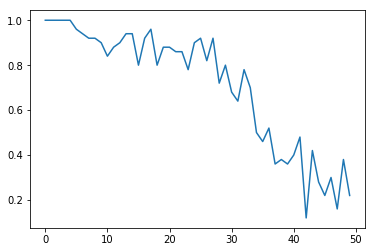

In [35]:
plt.plot(range(num_steps-1), avg_mag)
plt.show()